In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import seaborn as sns
import random

# random seed for reproducibility
np.random.seed(42)
random.seed(42)

class Agent:
    """Represents an agent with a belief system."""
    def __init__(self, name, prior, bias, update_rule="bayesian"):
        self.name = name
        self.prior = prior
        self.bias = bias
        self.update_rule = update_rule

    def update_belief(self, evidence):
        """Update the agent's belief based on evidence."""
        if self.update_rule == "bayesian":
            likelihood_safe = evidence["likelihood_safe"]
            likelihood_unsafe = evidence["likelihood_unsafe"]
            self.prior = (
                self.prior * likelihood_safe
                / (self.prior * likelihood_safe + (1 - self.prior) * likelihood_unsafe)
            )
        else:
            raise NotImplementedError("Only Bayesian updates are supported currently.")
        return self.prior

class Evidence:
    """Represents a piece of evidence."""
    def __init__(self, topic, polarity, credibility, likelihood_safe, likelihood_unsafe):
        self.topic = topic
        self.polarity = polarity
        self.credibility = credibility
        self.likelihood_safe = likelihood_safe
        self.likelihood_unsafe = likelihood_unsafe

class AgentNetwork:
    """Represents a network of agents and their influence on each other."""
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_agent(self, agent):
        self.graph.add_node(agent.name, agent=agent)

    def add_influence(self, source_name, target_name, weight):
        self.graph.add_edge(source_name, target_name, weight=weight)

    def update_beliefs(self, evidence):
        """Update beliefs of all agents, considering direct evidence and peer influence."""
        for agent_name in self.graph.nodes:
            agent = self.graph.nodes[agent_name]['agent']
            # Direct evidence update
            updated_belief = agent.update_belief({
                "likelihood_safe": evidence.likelihood_safe,
                "likelihood_unsafe": evidence.likelihood_unsafe
            })

            # Peer influence update
            for neighbor in self.graph.predecessors(agent_name):
                influence_weight = self.graph[neighbor][agent_name]['weight']
                neighbor_belief = self.graph.nodes[neighbor]['agent'].prior
                updated_belief += influence_weight * (neighbor_belief - agent.prior)

            # Update the agent's prior
            agent.prior = min(max(updated_belief, 0), 1)  # Keep within [0, 1]

# Preprocess Data for Evidence
def preprocess_data(fake_file, real_file):
    fake_claims = pd.read_csv(fake_file)
    real_claims = pd.read_csv(real_file)

    fake_claims['label'] = 0
    real_claims['label'] = 1
    claims = pd.concat([fake_claims, real_claims])

    # Extract features using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(claims['title'])

    # Assign polarity and credibility - could use different more concrete approach for this in the future
    claims['polarity'] = claims['label'].apply(lambda x: "positive" if x == 1 else "negative")
    claims['credibility'] = tfidf_matrix.mean(axis=1).A.flatten()

    return claims

In [27]:
# random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Test the System
def run_simulation(fake_file, real_file, n_agents):
    # Create Agent Network
    agent_network = AgentNetwork()

    # Define agents
    agents = [
        Agent(name=f"Agent_{i}", prior=np.random.uniform(0.1, 0.9), bias=np.random.choice(["skeptical", "supportive", "neutral"]))
        for i in range(n_agents)
    ]

    for agent in agents:
        agent_network.add_agent(agent)

    # Define random influences
    for i in range(len(agents)):
        for j in range(len(agents)):
            if i != j and random.random() < 0.3:  # 30% chance of connection
                agent_network.add_influence(f"Agent_{i}", f"Agent_{j}", weight=np.random.uniform(0.1, 0.5))

    # Preprocess evidence data
    claims = preprocess_data(fake_file, real_file)

    # Simulate updates
    beliefs = {agent.name: [] for agent in agents}
    for _, row in claims.iterrows():
        evidence = Evidence(
            topic="COVID-19",
            polarity=row['polarity'],
            credibility=row['credibility'],
            likelihood_safe=0.8 if row['label'] == 1 else 0.5,
            likelihood_unsafe=0.2 if row['label'] == 1 else 0.5
        )
        agent_network.update_beliefs(evidence)

        # Record beliefs
        for agent in agents:
            beliefs[agent.name].append(agent.prior)

    # Plot Belief Evolution
    for agent_name, belief_list in beliefs.items():
        plt.plot(belief_list, label=agent_name)
    plt.xlabel("Time (Evidence Updates)")
    plt.ylabel("Belief (Posterior)")
    plt.title(f"Belief Evolution in Agent Network (N = {n_agents})")
    plt.legend()
    plt.savefig(f"Belief Evolution in Agent Network (N = {n_agents})")
    plt.show()

    # Plot Initial vs. Final Beliefs
    initial_beliefs = [beliefs[agent.name][0] for agent in agents]
    final_beliefs = [beliefs[agent.name][-1] for agent in agents]
    plt.bar(range(len(agents)), initial_beliefs, alpha=0.7, label="Initial")
    plt.bar(range(len(agents)), final_beliefs, alpha=0.7, label="Final")
    plt.xlabel("Agents")
    plt.ylabel("Belief")
    plt.title(f"Initial vs. Final Beliefs (N = {n_agents})")
    plt.legend()
    plt.savefig(f"Individual Final Beliefs (N = {n_agents})")
    plt.show()

    # Heatmap of Peer Influence Weights
    weights = nx.to_numpy_array(agent_network.graph, weight='weight')
    sns.heatmap(weights, annot=False, cmap="coolwarm")
    plt.title("Peer Influence Weights")
    plt.show()

    # Credibility vs. Belief Update Scatter Plot
    credibility = claims['credibility'][:len(final_beliefs)]
    belief_changes = [final - initial for initial, final in zip(initial_beliefs, final_beliefs)]
    plt.scatter(credibility, belief_changes)
    plt.xlabel("Credibility")
    plt.ylabel("Belief Change")
    plt.title("Credibility vs. Belief Update")
    plt.show()

    # Agent Clustering via PCA
    pca = PCA(n_components=2)
    belief_matrix = np.array([beliefs[agent.name] for agent in agents])
    reduced = pca.fit_transform(belief_matrix.T)
    plt.scatter(reduced[:, 0], reduced[:, 1])
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Agent Clustering via PCA")
    plt.show()

    # Time-to-Equilibrium Analysis
    time_to_eq = [np.argmax(np.abs(np.diff(beliefs[agent.name])) < 0.01) for agent in agents]
    plt.bar(range(len(agents)), time_to_eq)
    plt.xlabel("Agents")
    plt.ylabel("Time Steps to Equilibrium")
    plt.title("Time-to-Equilibrium for Each Agent")
    plt.show()

In [28]:
path = '05-01-2020/'
fake_csv = path + "ClaimFakeCOVID-19.csv"
real_csv = path + "ClaimRealCOVID-19.csv"

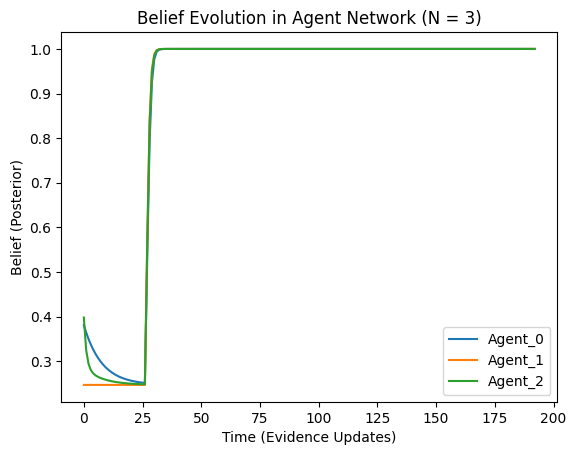

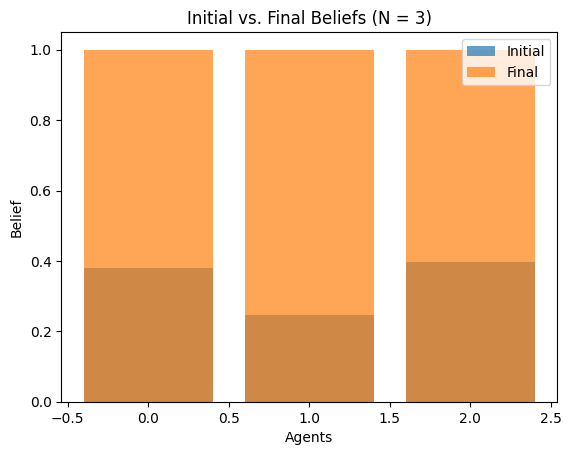

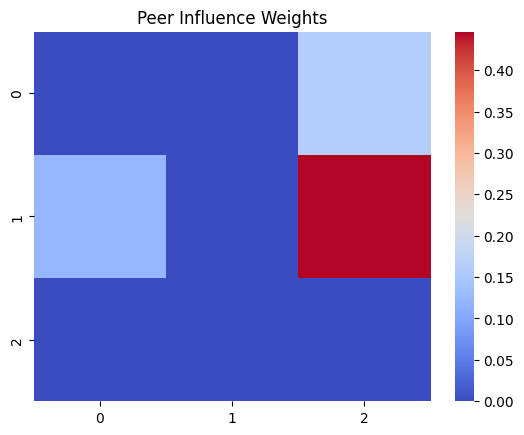

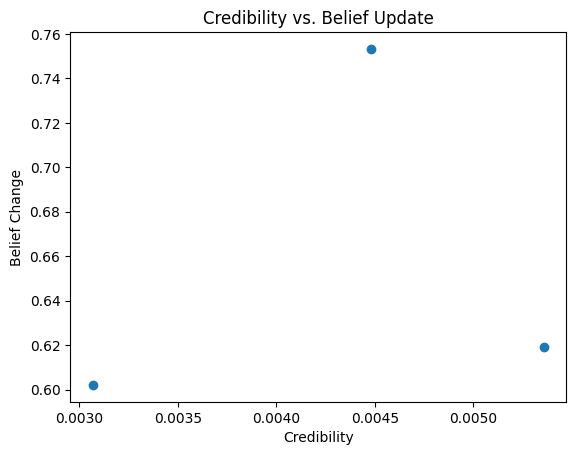

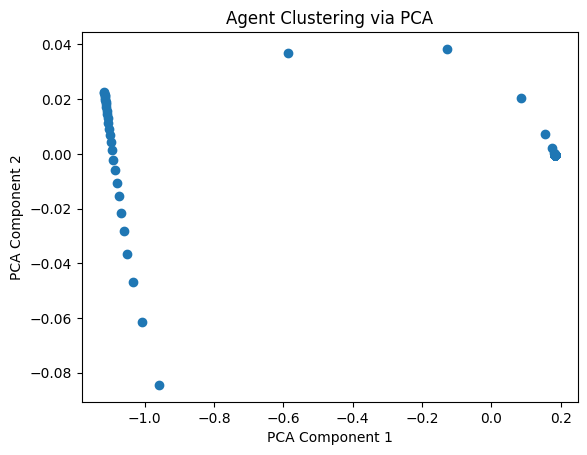

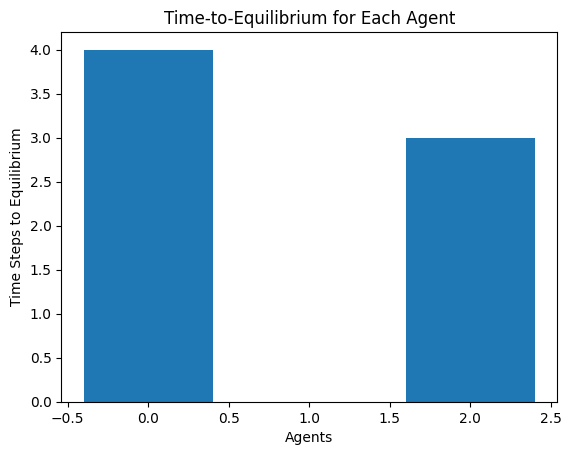

In [29]:
run_simulation(fake_csv, real_csv, 3)

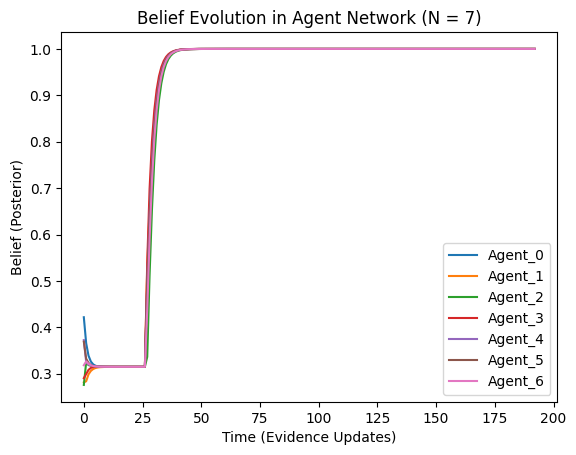

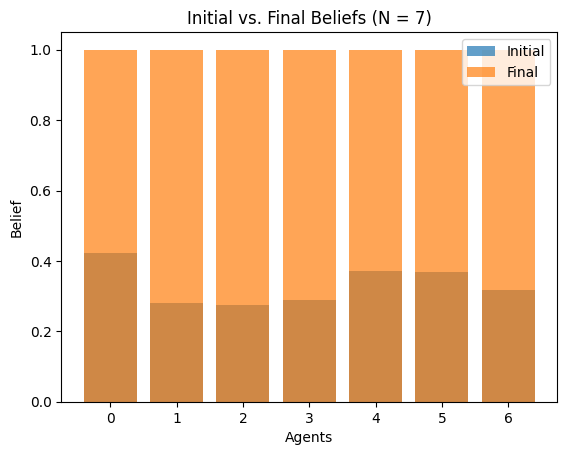

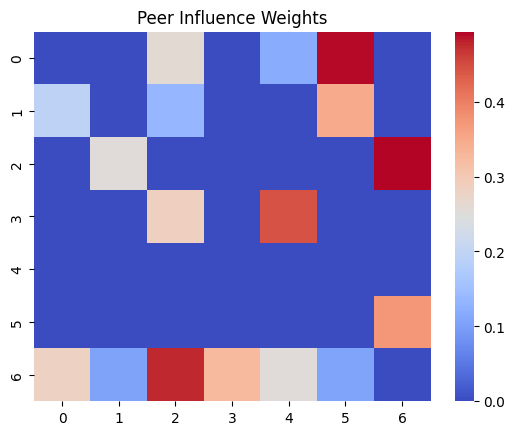

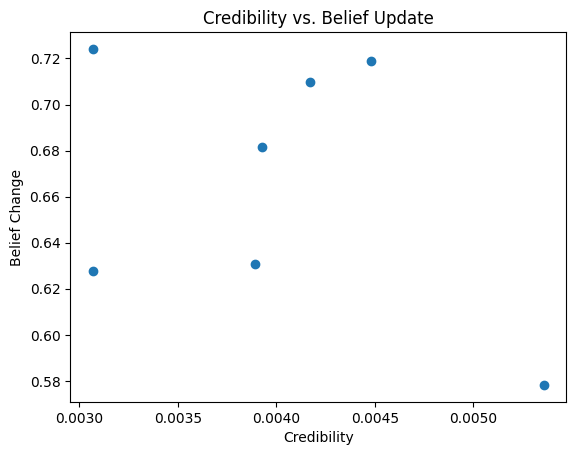

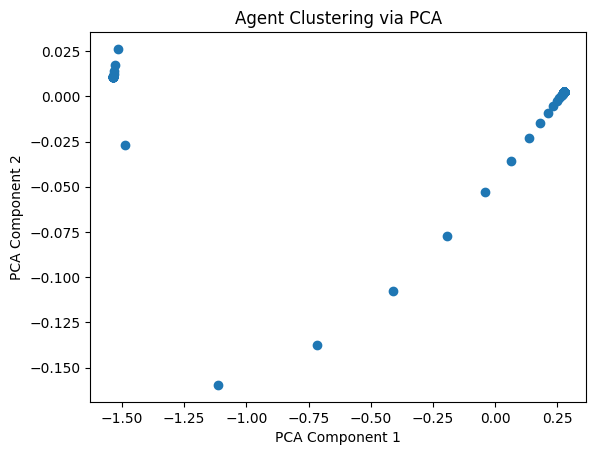

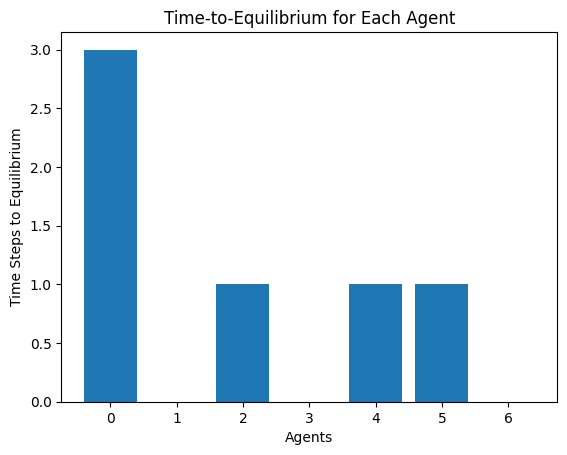

In [30]:
run_simulation(fake_csv, real_csv, 7)

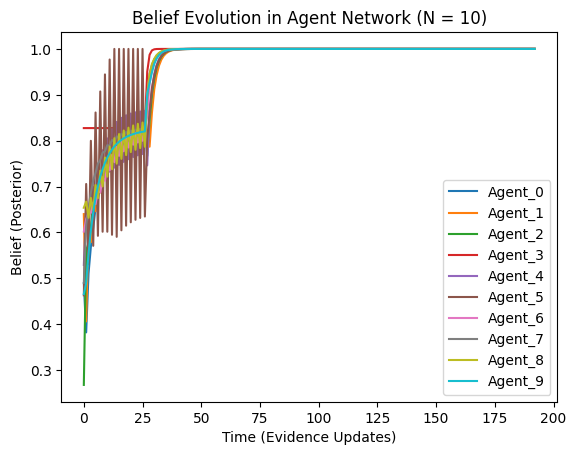

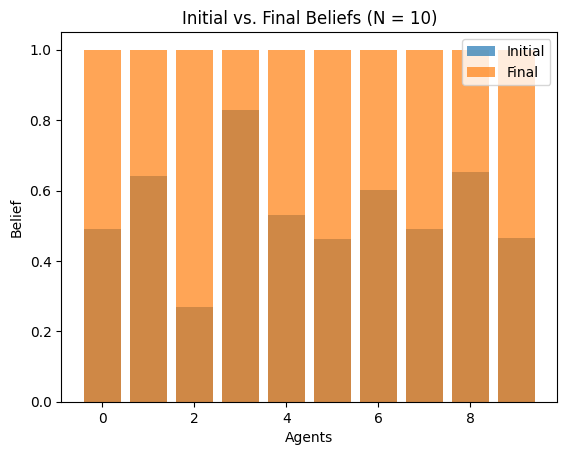

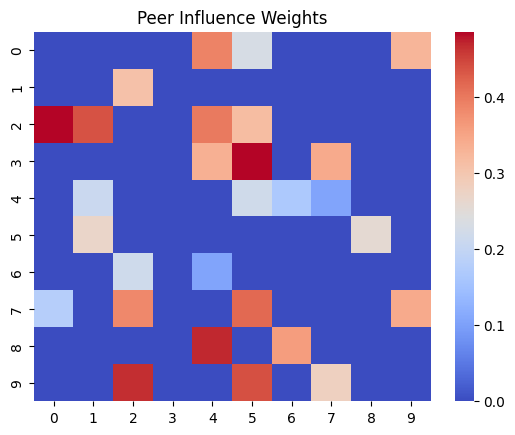

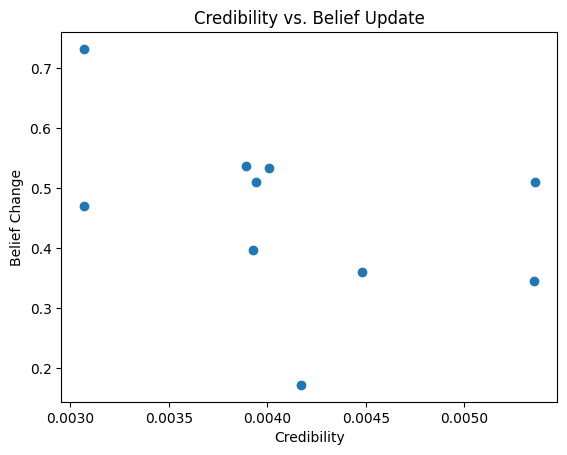

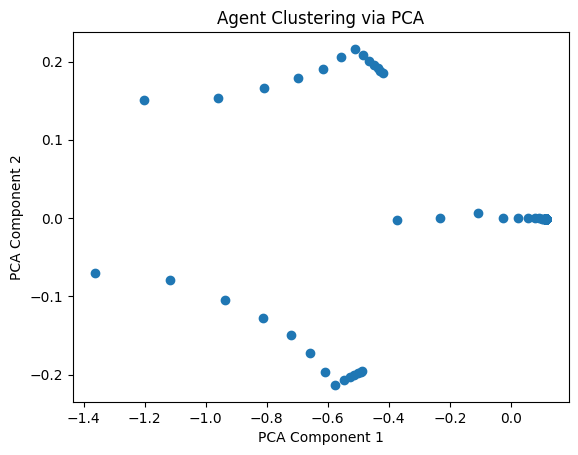

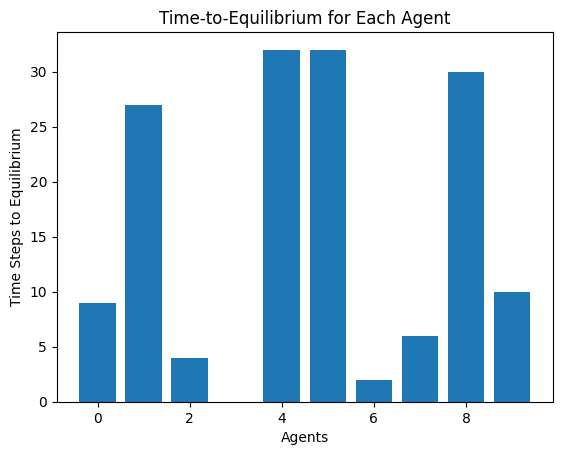

In [31]:
run_simulation(fake_csv, real_csv, 10)

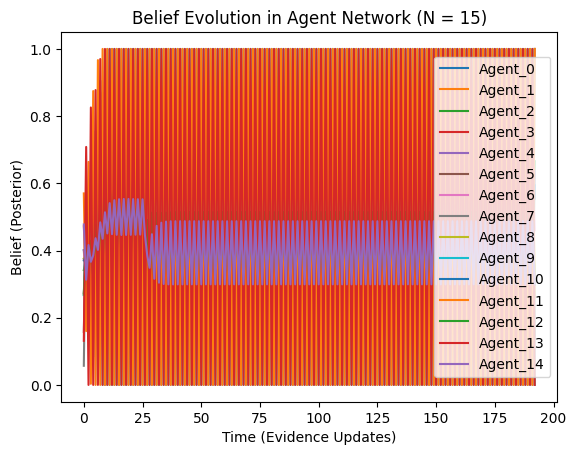

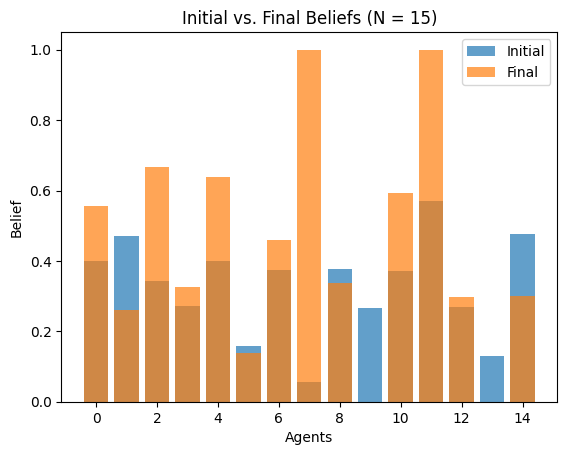

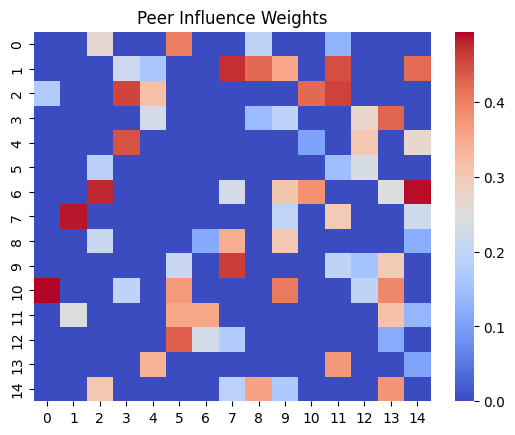

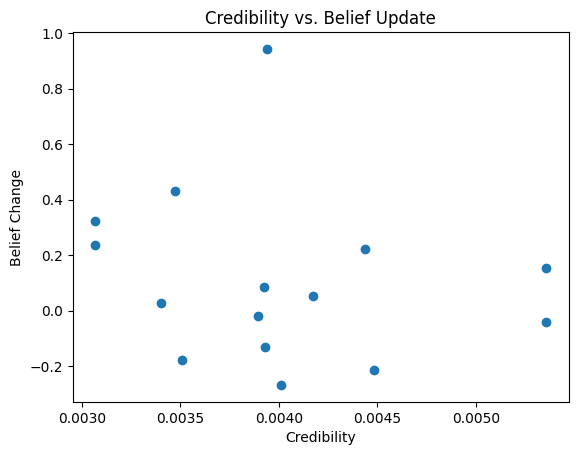

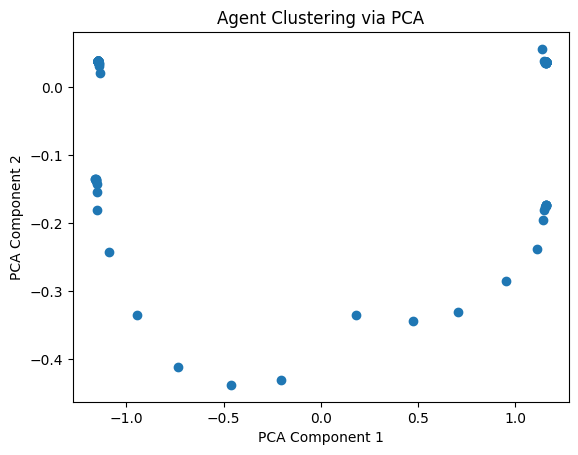

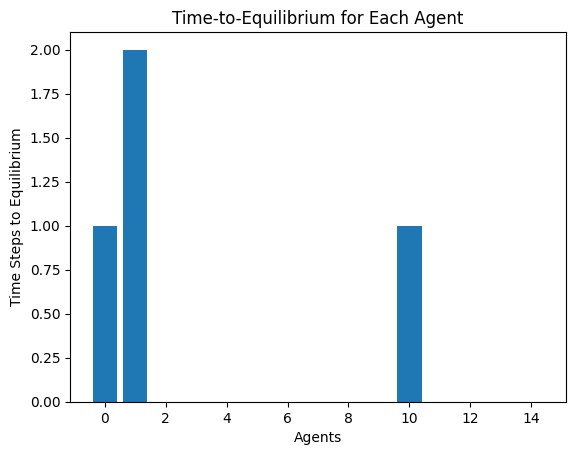

In [32]:
run_simulation(fake_csv, real_csv, 15)

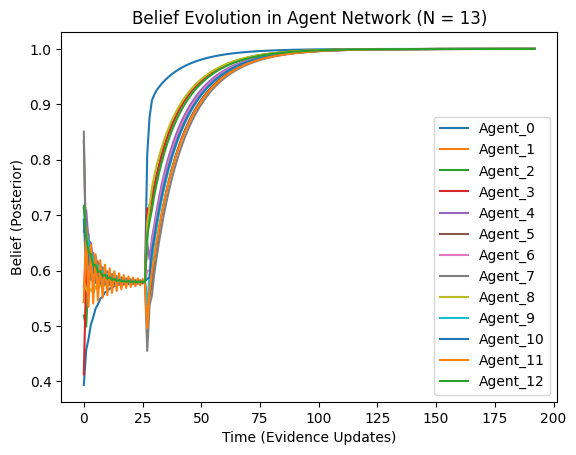

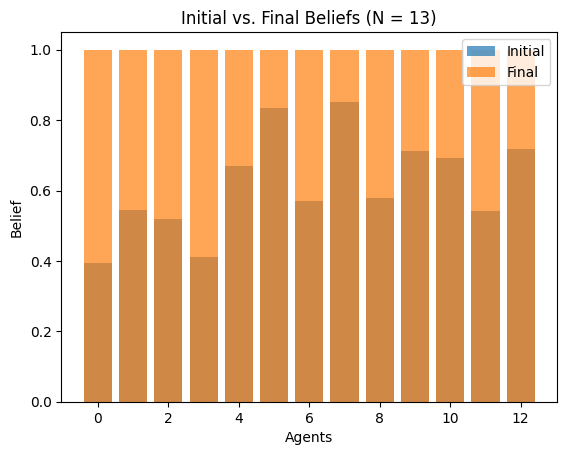

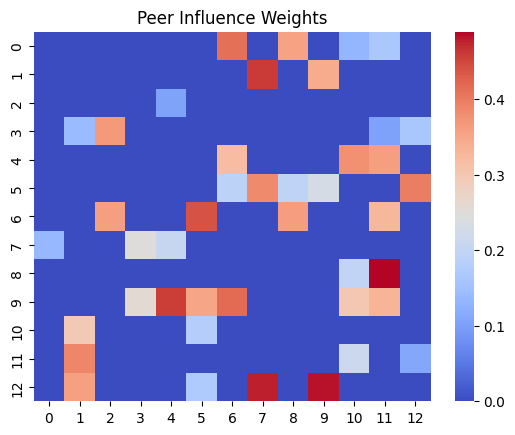

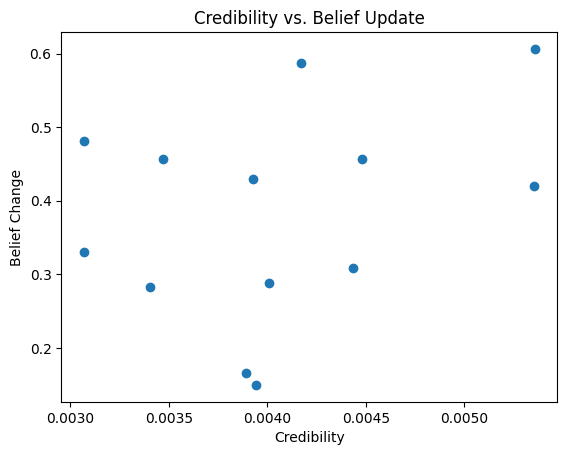

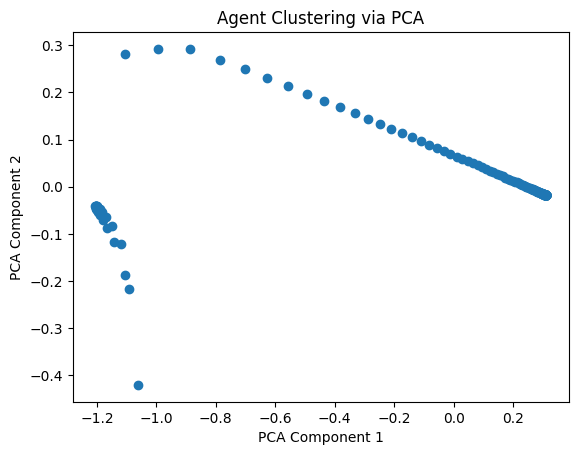

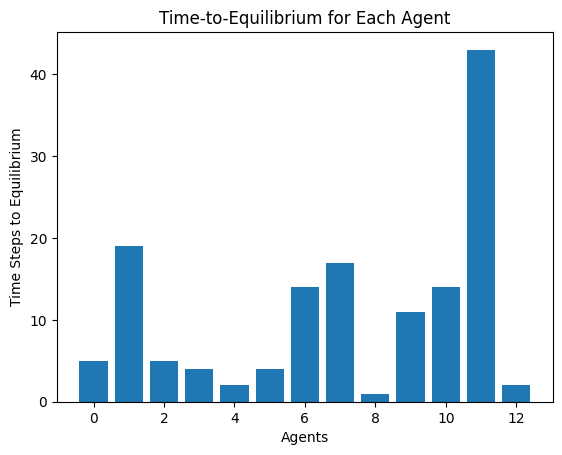

In [33]:
run_simulation(fake_csv, real_csv, 13)

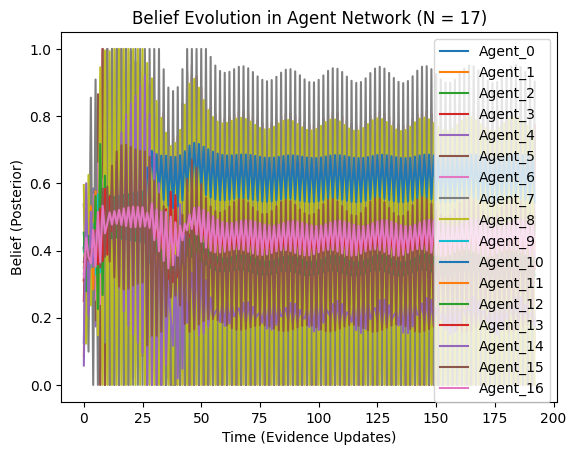

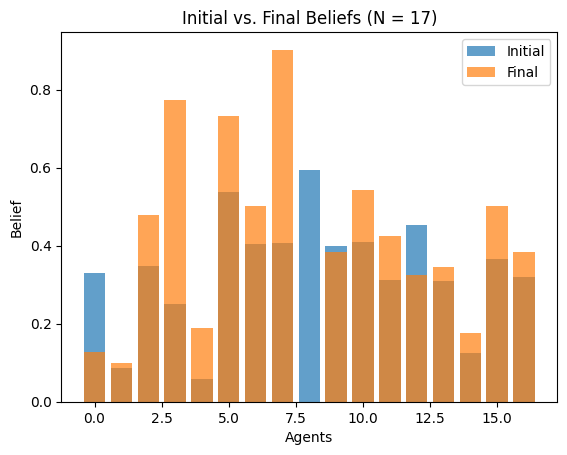

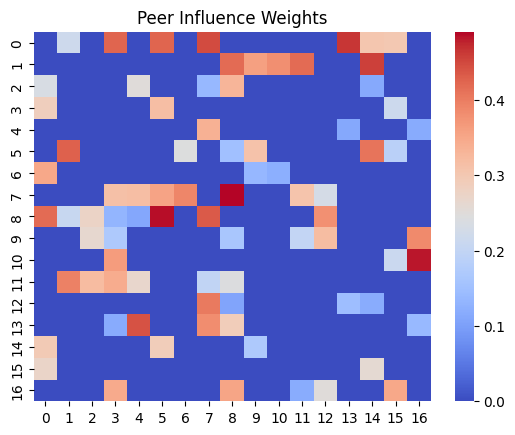

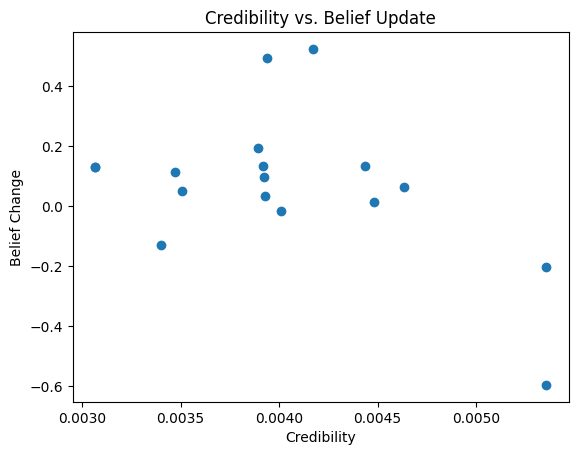

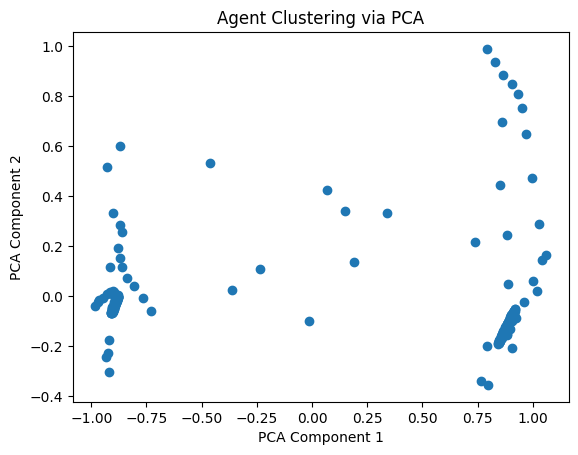

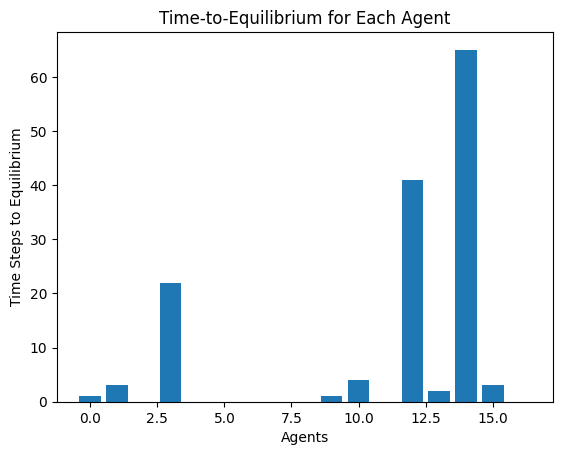

In [34]:
run_simulation(fake_csv, real_csv, 17)